In [1]:
import os
import requests, re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

In [2]:
DATA_DIR = os.path.join('..', 'data')

SCHOOL_SHOOTINGS_BEFORE_2000_FILEPATH = os.path.join(DATA_DIR, 'before_20th_century_shootings.csv')
SCHOOL_SHOOTINGS_AFTER_2000_FILEPATH = os.path.join(DATA_DIR, '20th_century_school_shootings.csv')


## Join Data

In [3]:
before_2000_df = pd.read_csv(SCHOOL_SHOOTINGS_BEFORE_2000_FILEPATH)
after_2000_df = pd.read_csv(SCHOOL_SHOOTINGS_AFTER_2000_FILEPATH)

df = pd.concat([before_2000_df, after_2000_df])

In [4]:
df.reset_index(inplace=True)

## Create Features

In [5]:
def find_shooter_number_in_str(text):
    match = re.match('.*(\d)+\]', text)
    if match:
        return match[1]
    return 0
find_shooter_number_in_str('2[n 1]')
# find_shooter_number_in_str('2')

'1'

In [6]:
reformatted_injuries = df['Injuries'].str.replace('?', '0')
numeric_injuries = reformatted_injuries.str.replace('\D', '')

In [7]:
df['Shooter_Deaths'] = df['Deaths'].apply(find_shooter_number_in_str).astype(int)

In [8]:
df['Total_Injuries'] = df['Injuries'].apply(find_shooter_number_in_str).astype(int)

In [9]:
df['Victim_Deaths'] = df['Deaths'].apply(lambda d: d.split('[')[0]).astype(int)

In [10]:

df['Victim_Injuries'] = numeric_injuries.apply(lambda d: d.split('[')[0]).astype(int)

In [11]:
df['Total_Deaths'] = df['Victim_Deaths'] + df['Shooter_Deaths']

df['Total_Injuries'] = df['Victim_Injuries'] + df['Total_Injuries']

In [12]:

df['Year'] = df['Date'].astype(np.datetime64).apply(lambda a: a.year)

In [13]:
df['Decade'] = df['Year'].astype(str).apply(lambda a: a[:3]+'0').astype(int)

In [14]:
df['Total_Shootings'] = 1 # A dummy value which will be used in aggregates later

## Create specific DataFrames

In [15]:
df_mass_shootings = df[df['Total_Deaths'] >= 3]

In [16]:
df_by_decade = df.groupby('Decade').sum()
df_by_decade.reset_index(inplace=True)

In [17]:
df_mass_shootings_by_decade = df_mass_shootings.groupby('Decade').sum()
df_mass_shootings_by_decade.reset_index(inplace=True)

# Visualize Data

Text(0.5, 1.0, 'Number of Shootings Per Decade')

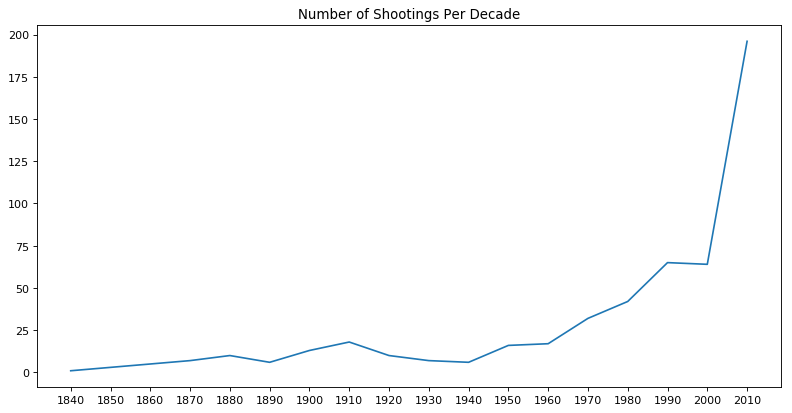

In [18]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_by_decade.Decade.astype(str), df_by_decade['Total_Shootings'])
plt.title('Number of Shootings Per Decade')

Text(0.5, 1.0, 'Number of Mass Shootings Per Decade')

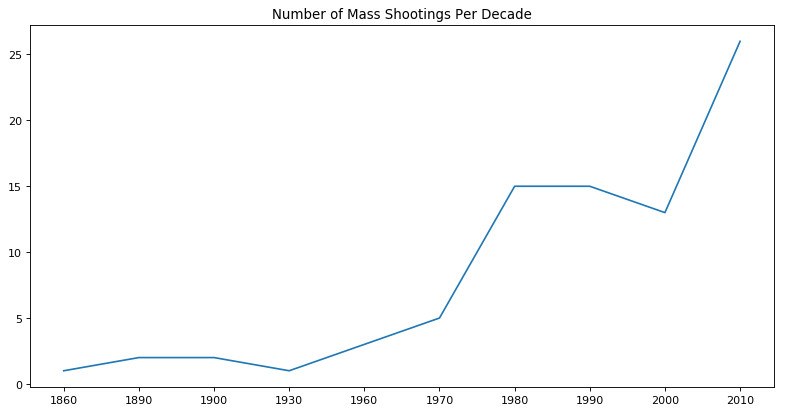

In [19]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_mass_shootings_by_decade.Decade.astype(str), df_mass_shootings_by_decade['Total_Shootings'])
plt.title('Number of Mass Shootings Per Decade')

Text(0.5, 1.0, 'Number of Victim Deaths Per Decade')

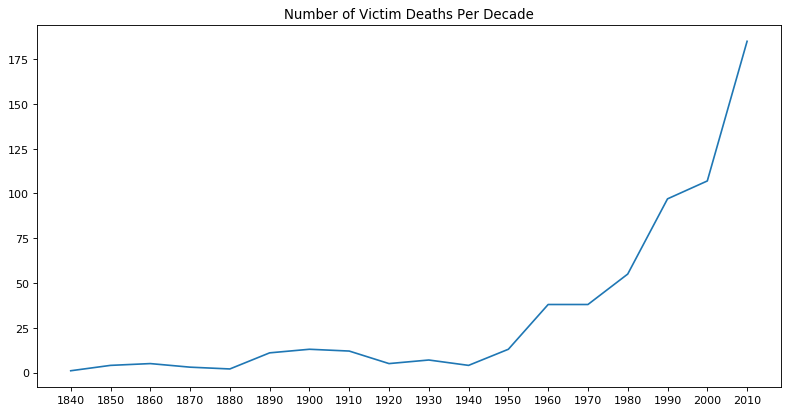

In [20]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_by_decade.Decade.astype(str), df_by_decade['Victim_Deaths'])
plt.title('Number of Victim Deaths Per Decade')

## Which decade was most significant in a shift of shootings

In [21]:
a = df_mass_shootings_by_decade['Total_Shootings']

In [22]:
def linear_regression_model(x, y = df_mass_shootings_by_decade['Decade'].values):
    model = LinearRegression()
    model.fit(x, y)
    r_sq = model.score(x, y)
    Y_pred = model.predict(x)
    
#     print('coefficient of determination:', r_sq)
    
    return [r_sq, model.intercept_, model.coef_, Y_pred]

In [23]:
x = df_mass_shootings_by_decade['Total_Shootings'].values.reshape((-1, 1))
linear_regression_model(x)

[0.6414215327719484,
 1908.8724811567452,
 array([4.83464082]),
 array([1913.70712198, 1918.54176281, 1918.54176281, 1913.70712198,
        1923.37640363, 1933.04568528, 1981.39209352, 1981.39209352,
        1971.72281188, 2034.57314259])]

In [24]:
is_1980 = np.zeros(len(df_mass_shootings_by_decade))
is_1980[df_mass_shootings_by_decade['Decade'] > 1980] = 1

In [25]:
x = df_mass_shootings_by_decade['Total_Shootings'].values.reshape((-1, 1))
linear_regression_model(x)

[0.6414215327719484,
 1908.8724811567452,
 array([4.83464082]),
 array([1913.70712198, 1918.54176281, 1918.54176281, 1913.70712198,
        1923.37640363, 1933.04568528, 1981.39209352, 1981.39209352,
        1971.72281188, 2034.57314259])]

In [26]:
# With indicator
x = np.array(list(zip(
    df_mass_shootings_by_decade['Total_Shootings'].values,
    is_1980)))
linear_regression_model(x)

[0.6494457733377119,
 1909.9768518518517,
 array([ 4.14351852, 15.43981481]),
 array([1914.12037037, 1918.26388889, 1918.26388889, 1914.12037037,
        1922.40740741, 1930.69444444, 1972.12962963, 1987.56944444,
        1979.28240741, 2033.14814815])]

### Interactive term with single linear explanatory variable

In [27]:
for decade in df_mass_shootings_by_decade.Decade:
    year_indicator = np.zeros(len(df_mass_shootings_by_decade))
    year_indicator[df_mass_shootings_by_decade['Decade'] > decade] = 1

    # With interaction
    x = np.array(list(zip(
        df_mass_shootings_by_decade.index.values,
        df_mass_shootings_by_decade.index.values * year_indicator,
    )))
    y = df_mass_shootings_by_decade['Total_Shootings'].values
    [rs, intercept, coef, Y_pred] = linear_regression_model(x, y)
    print('Decade {}: {:.0f}%'.format(decade, rs*100))

Decade 1860: 79%
Decade 1890: 80%
Decade 1900: 79%
Decade 1930: 80%
Decade 1960: 84%
Decade 1970: 90%
Decade 1980: 82%
Decade 1990: 81%
Decade 2000: 89%
Decade 2010: 79%


### Interactive term with single exponential explanatory variable

In [28]:
exponential_output = []
for decade in df_mass_shootings_by_decade.Decade:
    year_indicator = np.zeros(len(df_mass_shootings_by_decade))
    year_indicator[df_mass_shootings_by_decade['Decade'] > decade] = 1

    # With interaction
    x = np.array(list(zip(
        df_mass_shootings_by_decade.index.values,
        df_mass_shootings_by_decade.index.values * df_mass_shootings_by_decade.index.values * year_indicator,
    )))
    y = df_mass_shootings_by_decade['Total_Shootings'].values
    [rs, intercept, coef, Y_pred] = linear_regression_model(x, y)
    
    exponential_output.append(rs)
    print('Decade {}: {:.0f}%'.format(decade, rs*100))

Decade 1860: 89%
Decade 1890: 89%
Decade 1900: 89%
Decade 1930: 89%
Decade 1960: 90%
Decade 1970: 91%
Decade 1980: 83%
Decade 1990: 81%
Decade 2000: 89%
Decade 2010: 79%


Text(0.5, 1.0, 'Probability of exponential starting in given decade')

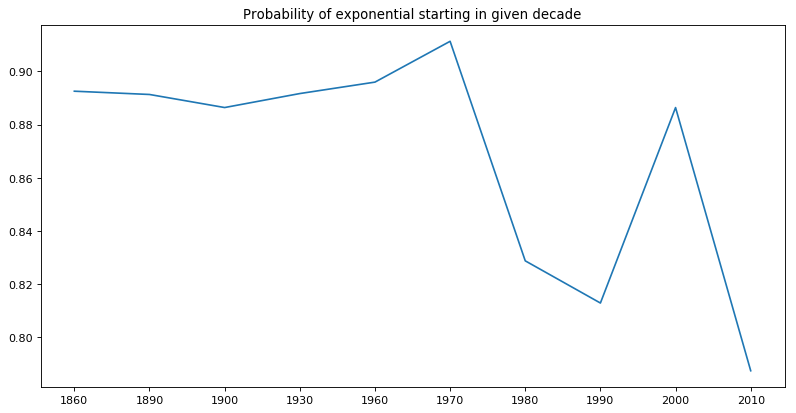

In [29]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_mass_shootings_by_decade.Decade.astype(str), exponential_output)
plt.title('Probability of exponential starting in given decade')

### Does exponential start at 1970?

In [30]:
decade = 1970
year_indicator = np.zeros(len(df_mass_shootings_by_decade))
year_indicator[df_mass_shootings_by_decade['Decade'] > decade] = 1

# With interaction
x = np.array(list(zip(
    df_mass_shootings_by_decade.index.values,
    df_mass_shootings_by_decade.index.values * df_mass_shootings_by_decade.index.values * year_indicator,
)))
y = df_mass_shootings_by_decade['Total_Shootings'].values
[rs, intercept, coef, Y_pred] = linear_regression_model(x, y)

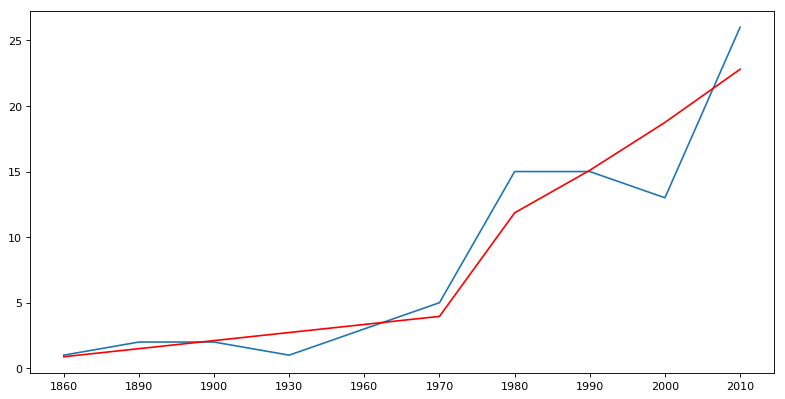

In [31]:
x1 = [xlist[0] for xlist in x]
x2 = [xlist[1] for xlist in x]

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_mass_shootings_by_decade.Decade.astype(str), df_mass_shootings_by_decade['Total_Shootings'])

plt.plot(df_mass_shootings_by_decade.Decade.astype(str), Y_pred, color='red')
plt.show()

### Does Exponential Start at 1990?

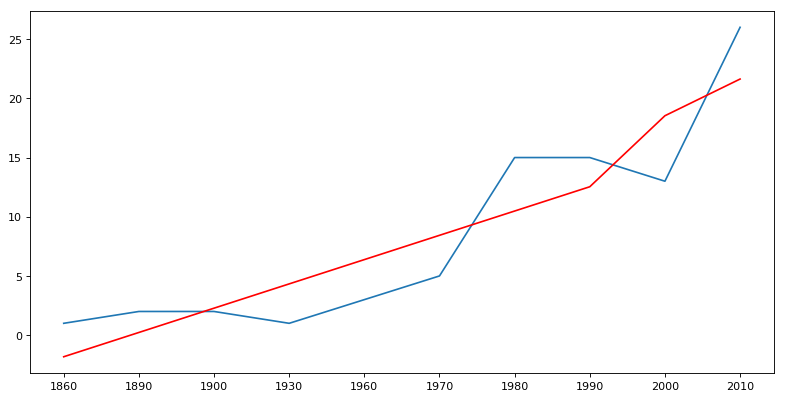

In [32]:
decade = 1990
year_indicator = np.zeros(len(df_mass_shootings_by_decade))
year_indicator[df_mass_shootings_by_decade['Decade'] > decade] = 1

# With interaction
x = np.array(list(zip(
    df_mass_shootings_by_decade.index.values,
    df_mass_shootings_by_decade.index.values * df_mass_shootings_by_decade.index.values * year_indicator,
)))
y = df_mass_shootings_by_decade['Total_Shootings'].values
[rs, intercept, coef, Y_pred] = linear_regression_model(x, y)

x1 = [xlist[0] for xlist in x]
x2 = [xlist[1] for xlist in x]

plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_mass_shootings_by_decade.Decade.astype(str), df_mass_shootings_by_decade['Total_Shootings'])

plt.plot(df_mass_shootings_by_decade.Decade.astype(str), Y_pred, color='red')
plt.show()